In [198]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [240]:
class vec():
    def __init__(self, x, y, z):
        (self.x, self.y, self.z) = (x, y, z)
    
    def __mul__(self, other):
        return vec(self.x * other, self.y * other, self.z * other)
    
    def __add__(self, other):
        return vec(self.x + other.x, self.y + other.y, self.z + other.z)
    
    def __sub__(self, other):
        return vec(self.x - other.x, self.y - other.y, self.z - other.z)
    
    def dot(self, other):
        return (self.x * other.x) + (self.y * other.y) + (self.z * other.z)
    
    def __abs__(self):
        return self.dot(self)
    
    def length(self):
        return np.sqrt(self.__abs__())
       
    def normalize(self):
        return self * (1/self.length()) if self.length() else self
    
    def cosine(self, other, step =1):
        return (self.dot(other)*(1/(self.length()*other.length())))**step
      
    def components(self):
        return (self.x, self.y, self.z)
class color(vec):
    pass

In [260]:
a = vec(1,0,0)
b = vec(1,0+0.1,0)
a.cosine(b,100)

0.6080388246889575

In [200]:
class Sphere:
    def __init__(self, center, radius, color, specular = 0, sphere_type = 'default',reflective=0):
        self.center = center
        self.radius = radius
        self.color = color
        self.specular = specular
        self.type = sphere_type
        self.reflective = reflective

    def normal(self, outer_point):
        return (outer_point - self.center).normalize()

In [201]:
class Light:
    def __init__(self, light_type, intensity, direction):
        self.type = light_type
        self.intensity = intensity
        self.direction = direction

In [202]:
def intersection(O, D, sphere):
    a = abs(D)
    b = 2 * D.dot(O - sphere.center)
    c = abs(O - sphere.center) - (sphere.radius * sphere.radius)
    disc = (b ** 2) - (4 * a *c)
    h0, h1 = np.inf, np.inf
    if disc > 0:
        h0 = (-b - np.sqrt(disc)) / (2*a)
        h1 = (-b + np.sqrt(disc)) / (2*a) 
        h0, h1 = min(h0, h1), max(h0, h1)
        if h1 >= 0:
            return h1 if h0 < 0 else h0
    return np.inf

In [203]:
def nearest_intersection(O, D, scene):
    nearest = np.inf
    nearest_sphere = None
    for sphere in scene[0]:
        dist = intersection(O, D, sphere)
        if dist<nearest:
            nearest = dist
            nearest_sphere = sphere
    return nearest_sphere, nearest

In [204]:
def refl_ligth(L, N):
    return N*N.dot(L)*2 - L
def calc_light(P, N, V, specular):
    intensity = 0
    for light in scene[1]:
        if light.type == 'ambient':
            intensity += light.intensity
        else:
            L = light.direction - P
                
            shadow_sphere, shadow_t = nearest_intersection(P+L*0.0001, L, scene)
            if shadow_t != np.inf:
                if shadow_sphere.type == 'default':
                    continue
                 
            n_dot_l = N.dot(L)
            if n_dot_l > 0:
                intensity += light.intensity*n_dot_l/(N.length()*L.length())
             
            
            if specular != 0:
                R = refl_ligth(L, N)
                r_dot_v = R.dot(V)
                if r_dot_v > 0:
                    intensity += light.intensity*pow(r_dot_v/(R.length()*V.length()), specular)
            
    return intensity

In [215]:
vec(R.x,R.y,R.z).x = 3

In [251]:
def trace_ray(O, D, scene, recursion_depth=3):
    nearest_sphere, nearest = nearest_intersection(O, D, scene)
    cross = O + D*nearest
    if nearest_sphere != None:
        if nearest_sphere.type!='default':
            return nearest_sphere.color
        local_color = nearest_sphere.color*calc_light(cross, nearest_sphere.normal(cross), D*-1, nearest_sphere.specular)
        
        r = nearest_sphere.reflective
        if (recursion_depth <= 0) or (r <= 0):
            return local_color

        R = refl_ligth(D*-1, nearest_sphere.normal(cross))
        reflected_color = (trace_ray(cross+R*0.001, R, scene,recursion_depth - 1)+\
                            trace_ray(cross+R*0.001, vec(R.x+0.1,R.y,R.z), scene,recursion_depth - 1)*\
                           R.cosine(vec(R.x+0.1,R.y,R.z),100)+\
                            trace_ray(cross+R*0.001, vec(R.x,R.y+0.1,R.z), scene,recursion_depth - 1)*\
                           R.cosine(vec(R.x,R.y+0.1,R.z),100)+\
                            trace_ray(cross+R*0.001, vec(R.x,R.y,R.z+0.1), scene,recursion_depth - 1)*\
                           R.cosine(vec(R.x,R.y,R.z+0.1),100))*(1/(1+3*R.cosine(vec(R.x,R.y,R.z+0.1),100)))
            

        return local_color*(1 - r) + reflected_color*r
    return color(0, 0, 0)

In [249]:
(w,h) = (400, 400)
screen = (-1, -1 * (h / w), 1, 1 * (h / w))
O = vec(0, 0, 0)
img = np.zeros((h, w, 3))

In [257]:
scene = [[
    Sphere(vec(0.9, 0, 3), 0.4, color(1, 0, 0), specular = 0,reflective=0.6),
    Sphere(vec(-0.9, 0, 3), 0.4, color(0, 1, 0),specular = 10,reflective=0.4),
    Sphere(vec(0, 0, 2.2), 0.5, color(0, 0, 1), specular = 1000,reflective=0.2),
    Sphere(vec(0.7, 0.7, 2), 0.1, color(1, 1, 1), specular = 0, sphere_type = 'ligntning'),
    Sphere(vec(0, -99999.5, 3), 99999, color(0.2, 0.5, 1), specular = 0),
    ],
    [Light('ambient', 0.2, vec(0, 0, 0)),
#      Light('point', 0.6, vec(2, 2, 0)),
     Light('point', 0.2, vec(0.7-0.1, 0.7, 2)),
     Light('point', 0.2, vec(0.7+0.1, 0.7, 2)),
     Light('point', 0.2, vec(0.7, 0.7-0.1, 2)),
#      Light('point', 0.6, vec(1, 1.8+0.2, 4)),
     Light('point', 0.2, vec(0.7, 0.7, 2-0.1)),
#      Light('point', 0.2, vec(1, 1.8, 4+0.2)),
#      Light('point', 0.6, vec(2, 2, 0)),
#      Light('point', 0.3, vec(0, 0, 0)),
    ]
    ]

100%|██████████| 400/400 [01:28<00:00,  4.55it/s]


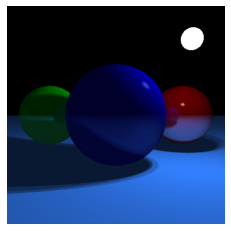

In [258]:
img = np.zeros((h, w, 3))
for i, x in enumerate(tqdm(np.linspace(screen[0], screen[2], w))):
    for j, y in enumerate(np.linspace(screen[1], screen[3], h)):
        col = np.zeros(3)
        D = vec(x, y, 2).normalize()
        col[:] = trace_ray(O, D, scene).components()
        img[h - j - 1, i, :] = col
plt.axis('off')
plt.imshow(img)